###### Imports


In [53]:
# Imports
from qiime2 import Metadata
import pandas as pd
from qiime2 import Artifact, sdk
from ete3 import Tree, PhyloTree, TreeNode, TreeStyle
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO

# Useful functions
import matplotlib
%matplotlib inline
matplotlib.use('module://ipykernel.pylab.backend_inline')
pm = sdk.PluginManager()
def see(artifact):
    from_format = artifact.format
    if issubclass(from_format, sdk.plugin_manager.SingleFileDirectoryFormatBase):
        from_format = artifact.format.file.format
    return set(pm.transformers[from_format].keys())
import os
import pandas
import qiime2
import tempfile

def v2frame(viz_fp: str) -> list:
    '''viz_fp is a path to the qiime2 visualization object'''
    viz = qiime2.Visualization.load(viz_fp)
    with tempfile.TemporaryDirectory() as tmpdir:
        viz.export_data(tmpdir)
        fp = os.path.join(tmpdir, 'quality-plot.html')
        ov = os.path.join(tmpdir, 'overview.html')
        dfs = pandas.read_html(fp, index_col=0)
        df2s = pandas.read_html(ov, index_col=0)
    return dfs + df2s

def get_tax(tax: str) -> str:
    if not ';' in tax:
        return tax
    tax = tax.split(';')
    for t in tax[::-1]:
        if ' ' == t[0]:
            if 'uncultured' in t:
                continue
            return t.strip().replace(';', '')
        if t[-1:-3] == '_s':
            continue
        return t

metadata = pd.read_csv('sys_metadata.tsv', sep='\t').drop(0).reset_index()

### Jellyfish microbiome analysis

#### Sample background

The data is the microbiome of the arms


#### Importing the data

The fastq files contain single-end reads, sequenced with the 454 GS FLX+ via a pyrosequencing approach
https://trace.ncbi.nlm.nih.gov/Traces/study/?acc=SRP254518&o=acc_s%3Aa&s=SRR11447095,SRR11447093,SRR11447098

```{bash}
qiime tools import \
    --type 'SampleData[SequencesWithQuality]' \
    --input-path data.tsv \
    --output-path jelly.qza \
    --input-format SingleEndFastqManifestPhred33V2
```


### Raw data exploration

The initial data exploration was performed with fastqc. There is a high variation in read length, though the majority are in the 450 - 500 bp range. As expected for short-read sequencing, read quality drops at higher read lengths, necessitating trimming. Surprisingly, the sample has little adapter content.

#### Blasting overrepresenting sequences

To get a rough idea of what microorganisms were represented most in the sample, I used data from `fastqc`'s overrepresented sequences module.
The sequences listed in the module were combined, clustered together to remove redundant reads with `cd-hit`, then blasted against the custom 16s rRNA database.

- `cd-hit` grouped 238 overrepresented sequences from the 7 samples into only 17 clusters
- The following describes the best 3 hits for the top 3 most overrepresented sequences
  - 1. Entoplasma, Mesoplasma, Lebetimonas
  - 2. _Ferruginivarius sediminum_, Azospirillum, Desulfosporosinus
  - 3. Flavobacteria, Dokdonia, Joostella


### Quality control

The dada2 plugin denoises sequences and dereplicates them


##### Clustering

Once the sequences have been dereplicated, they can be clustered them into operational taxonomic units (OTUs). Given that jellyfish microorganisms may not be as well represented in databases, I'll be using de novo clustering rather than reference-based


## Phylogeny reconstruction

- Reconstructing a phylogenetic tree from the otu sequences may allow us to identify unknown otus by placing them in relation to those that were identified.
- qiime2 offers several different methods for


In [32]:
from skbio.tree import TreeNode
from io import StringIO
fasttree = PhyloTree(Artifact.load('results/6-RootedTrees/Jelly-FastTree_RootedTree.qza').view(TreeNode).__str__(), format=1)
iqtree = Tree(Artifact.load('results/6-RootedTrees/Jelly-IQTREE_RootedTree.qza').view(TreeNode).__str__(), format=1)
raxml = Tree(Artifact.load('results/6-RootedTrees/Jelly-RAxML_RootedTree.qza').view(TreeNode).__str__(), format=1)
for tree in [fasttree, iqtree, raxml]:
    for node in tree.traverse():
        if node.is_leaf():
            node.name = blast[node.name]
style = TreeStyle()
style.scale = 300
# style.mode = "c"
style.branch_vertical_margin = 15
fasttree.show(tree_style=style)

## Diversity analyses


In [47]:
# Graphing functions
def plot_pcoa_2d(pcoa_data: pd.DataFrame, title: str,
                highlight: str):
    fig, ax = plt.subplots()
    classes = pcoa_data[highlight].unique()
    for c in classes:
        one_class = pcoa_data[pcoa_data[highlight] == c]
        ax.scatter(one_class.iloc[:, 0], one_class.iloc[:, 1], s=50)
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.legend(classes)
    ax.set_title(title)
    plt.show()

In [48]:
# Alpha diversity
pielou_e = Artifact.load('./results/7-Diversity/Jelly/Jelly-A_pielou_e.qza').view(pd.Series)
shannon = Artifact.load('./results/7-Diversity/Jelly/Jelly-A_shannon.qza').view(pd.Series)
simpson = Artifact.load('./results/7-Diversity/Jelly/Jelly-A_simpson.qza').view(pd.Series)
simpson_e = Artifact.load('./results/7-Diversity/Jelly/Jelly-A_simpson_e.qza').view(pd.Series)

# Beta diversity
pcoaBC = Artifact.load('results/8-Analysis/Jelly/Jelly-PCOA_B_braycurtis.qza').view(Metadata).to_dataframe().merge(metadata, left_index=True, right_on='sample-id')
pcoaJ = Artifact.load('results/8-Analysis/Jelly/Jelly-PCOA_B_jaccard.qza').view(Metadata).to_dataframe().merge(metadata, left_index=True, right_on='sample-id')
pcoaUu = Artifact.load('results/8-Analysis/Jelly/Jelly-PCOA_BPhylo_unweighted_unifrac.qza').view(Metadata).to_dataframe().merge(metadata, left_index=True, right_on='sample-id')
pcoaUn = Artifact.load('results/8-Analysis/Jelly/Jelly-PCOA_BPhylo_weighted_normalized_unifrac.qza').view(Metadata).to_dataframe().merge(metadata, left_index=True, right_on='sample-id')
pcoaWu = Artifact.load('results/8-Analysis/Jelly/Jelly-PCOA_BPhylo_weighted_unifrac.qza').view(Metadata).to_dataframe().merge(metadata, left_index=True, right_on='sample-id')

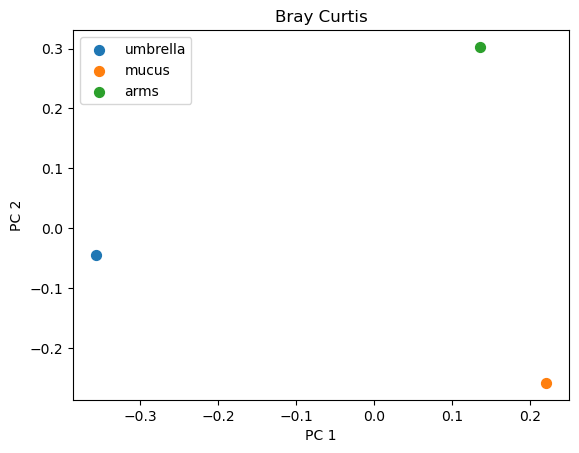

In [58]:
plot_pcoa_2d(pcoaUu, 'Bray Curtis', 'source')

## Data sources

- https://www.ebi.ac.uk/ena/browser/view/PRJEB8518
- https://docs.qiime2.org/2023.5/data-resources/ High-quality reference OTUs
- The `see` and `v2frame` functions were obtained from [this](https://forum.qiime2.org/t/how-to-capture-a-value-from-a-summary-and-pipe-it/19783/5) link via user thermokarst
